# **Book Recommendation Engine using KNN**

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

--2021-05-02 06:45:05--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  23.3MB/s    in 1.1s    

2021-05-02 06:45:07 (23.3 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


## Load the Data

The data consists of three tables: ratings, books info, and users info. But I will use only ratings table and book info table for this project.

In [3]:
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

## Explore the Data to Gain Insights

Let's take a quick look at a book dataset.

In [4]:
df_books

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber
...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger
271375,0525447644,From One to One Hundred,Teri Sloat
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271377,0192126040,Republic (World's Classics),Plato


In [5]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271378 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB


This dataset gives information about book details. There are 271,379 instances and 3 attributes: **isbn** (books are identified by their respective ISBN), **title** (book title), and **author** (book author).

Notice that the **author** attribute has only 271,378 non-null values, meaning that 1 book author is missing this feature. I will need to take care of this later.

Let's look at a summary of the attributes in this dataset.

In [6]:
df_books.describe()

,isbn,title,author
count,271379,271379,271378
unique,271379,242154,102042
top,1576737802,Selected Poems,Agatha Christie
freq,1,27,632


All attributes in this book dataset have object data type or not numerical. Notice that the unique values both in the **title** and **author** column were less than each total count values of them, which means there are same values in the **title** and **author** column.

Let's find out how many book title and book author that have same values and how many both of them belong to each value.

In [7]:
df_books.title.value_counts()

Selected Poems                                                                    27
Little Women                                                                      24
Wuthering Heights                                                                 21
Dracula                                                                           20
Adventures of Huckleberry Finn                                                    20
                                                                                  ..
Backpacks and Bookmarks: Ten Stories About School                                  1
Madeline and the Bad Hat (Madeline)                                                1
Sun Tzu: War and Management : Application to Strategic Management and Thinking     1
Jilted (Harlequin Presents)                                                        1
LAST SEEN ALIVE                                                                    1
Name: title, Length: 242154, dtype: int64

In [8]:
df_books.author.value_counts()

Agatha Christie                     632
William Shakespeare                 567
Stephen King                        524
Ann M. Martin                       423
Carolyn Keene                       373
                                   ... 
Catherine Crook de Camp (Editor)      1
W.C. Westmoreland                     1
Maurice Denuziere                     1
Steve Sheely                          1
Deanna Kizis                          1
Name: author, Length: 102042, dtype: int64

The book with title "Selected Poems" has the most same values in the **title** column and the book with author "Agatha Christie" has the most same values in the **author** column.

Now, let's take a quick look at a ratings dataset.

In [9]:
df_ratings

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0
...,...,...,...
1149775,276704,1563526298,9.0
1149776,276706,0679447156,0.0
1149777,276709,0515107662,10.0
1149778,276721,0590442449,10.0


In [10]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


This dataset provides a list of book ratings that users have given to books. There are 1,149,780 instances and 3 attributes: **user**, **isbn**, and **rating**.

Let's look at a summary of the attributes in this dataset.

In [11]:
df_ratings.describe()

,user,rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.842474e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


From the summary of the numerical attributes above, it seems **rating** has unevenly distribution. To ensure and to get clear visualization of the **rating** distribution, I will plot a histogram and check value counts for this column.

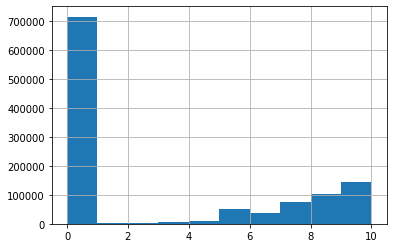

In [12]:
df_ratings.rating.hist()

In [13]:
df_ratings.rating.value_counts()

0.0     716109
8.0     103736
10.0     78610
7.0      76457
9.0      67541
5.0      50974
6.0      36924
4.0       8904
3.0       5996
2.0       2759
1.0       1770
Name: rating, dtype: int64

It's true, the ratings are very unevenly distributed, and the vast majority of ratings are 0.

Next, let's check value counts for **user** column and **isbn** column.

In [14]:
df_ratings.user.value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
158698        1
17920         1
277135        1
275086        1
187812        1
Name: user, Length: 105283, dtype: int64

In [15]:
df_ratings.isbn.value_counts()

0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
              ... 
0821762834       1
0446348260       1
1577484681       1
0684825066       1
089281330X       1
Name: isbn, Length: 340556, dtype: int64

It turns out, there are 105,283 users that have given rating to books in this dataset and user with id ***“11676”*** (**Top 1 Raters**) has given rating to 13,602 books. On the other side, there are 340,556 books that have given rating by users in this dataset and the book with isbn **“0971880107”** received the most rating counts.

At this stage, I curious if I create book recommendation system based on the book that received the most rating counts, what the results?

Let's find out the average rating and the number of rating each book received to know the results!

In [16]:
avg_rating = pd.DataFrame(df_ratings.groupby("isbn")["rating"].mean())
avg_rating["rating_count"] = pd.DataFrame(df_ratings.groupby("isbn")["rating"].count())
avg_rating.sort_values("rating_count", ascending = False).head()

,rating,rating_count
isbn,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


It turns out, the book that received the most rating counts wasn't highly rated at all. As result, if I was to use recommendations based on rating counts, I would definitely make mistake here. So, I need to have a better system.

Let's try create a book recommendation system using K-Nearest Neighbors to have a better system.

K-Nearest Neighbors is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.

## Prepare the Data

**To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.**

**Remove from the dataset users with less than 200 ratings**

In [17]:
user200rating = pd.DataFrame(df_ratings.user.value_counts())
user200rating = df_ratings[df_ratings.user.isin((user200rating[user200rating.user >= 200]).index)]
user200rating

,user,isbn,rating
1456,277427,002542730X,10.0
1457,277427,0026217457,0.0
1458,277427,003008685X,8.0
1459,277427,0030615321,0.0
1460,277427,0060002050,0.0
...,...,...,...
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0


Let's check value counts for **user** column after user with less than 200 ratings was removed.

In [18]:
user200rating.user.value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
36554       200
83671       200
99955       200
26883       200
225595      200
Name: user, Length: 905, dtype: int64

Now, there are 905 users left.

**Remove from the dataset books with less than 100 ratings**

In [19]:
book100rating = pd.DataFrame(df_ratings.isbn.value_counts())
user200r_book100r = user200rating[user200rating.isbn.isin((book100rating[book100rating.isbn >= 100]).index)]
user200r_book100r

,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0
...,...,...,...
1147304,275970,0804111359,0.0
1147436,275970,140003065X,0.0
1147439,275970,1400031346,0.0
1147440,275970,1400031354,0.0


Let's check value counts for **isbn** column and **user** column after book with less than 100 ratings was removed and user with less than 200 ratings was removed.

In [20]:
user200r_book100r.isbn.value_counts()

0971880107    365
0316666343    272
0060928336    221
0440214041    218
0385504209    217
             ... 
0451191145     23
039592720X     23
0684833395     22
0091867770     19
0671027344     16
Name: isbn, Length: 731, dtype: int64

In [21]:
user200r_book100r.user.value_counts()

11676     660
35859     348
16795     297
76352     291
60244     259
         ... 
30509       1
203820      1
241198      1
172888      1
142454      1
Name: user, Length: 888, dtype: int64

Finally, there are 731 books and 888 users left.

In order to prepare data to get final data (prepared and cleaned data) in form of 2D matrix, I combine books data (df_books) with prepared ratings data (user200r_book100r).

Now, let's combine both of the dataset.

In [22]:
combine = pd.merge(user200r_book100r, df_books, on = "isbn")
combine

,user,isbn,rating,title,author
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
...,...,...,...,...,...
49512,238864,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49513,251843,0399149325,1.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49514,253821,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell
49515,265115,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...,Patricia Cornwell


Let's take a quick look at this combined data to get quick description of this data.

In [23]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49517 entries, 0 to 49516
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49517 non-null  int32  
 1   isbn    49517 non-null  object 
 2   rating  49517 non-null  float32
 3   title   49517 non-null  object 
 4   author  49517 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 1.9+ MB


There are no missing values at each columns. So, it's good!

Next, let's check the rating distribution of this combined dataset.

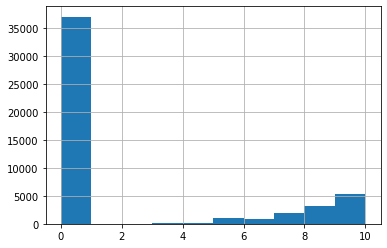

In [24]:
combine.rating.hist()

It turns out that this combined data still has an uneven distribution.

Let's also check value counts for **isbn** column and **user** column after both data was combined.

In [25]:
combine.isbn.value_counts()

0971880107    365
0316666343    272
0060928336    221
0440214041    218
0385504209    217
             ... 
076790592X     23
039592720X     23
0451204530     23
0684833395     22
0671027344     16
Name: isbn, Length: 727, dtype: int64

In [26]:
combine.user.value_counts()

11676     656
35859     347
16795     297
76352     291
23768     259
         ... 
30509       1
35433       1
142454      1
173632      1
241198      1
Name: user, Length: 888, dtype: int64

It turns out, the number of books were reduced to 727 but the number of users remains the same, which was 888.

Let's also check value counts for the remaining columns.

In [27]:
combine.title.value_counts()

Wild Animus                        365
The Lovely Bones: A Novel          272
Bridget Jones's Diary              255
The Nanny Diaries: A Novel         230
A Painted House                    226
                                  ... 
Code to Zero                        23
Interpreter of Maladies             23
Atlas Shrugged                      23
Catch 22                            22
The Perks of Being a Wallflower     16
Name: title, Length: 673, dtype: int64

In [28]:
combine.author.value_counts()

John Grisham       1777
James Patterson    1728
Nora Roberts       1662
Stephen King       1424
Sue Grafton        1293
                   ... 
Jack Kerouac         24
Ayn Rand             23
Jhumpa Lahiri        23
Joseph Heller        22
Stephen Chbosky      16
Name: author, Length: 319, dtype: int64

Now, I need to drop the author column. Because in this challenge of this project, the KNN model for book recommendation system will only consider about ratings that users have given to books.

In [29]:
combine = combine.drop(["author"], axis = 1)
combine

,user,isbn,rating,title
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...
...,...,...,...,...
49512,238864,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...
49513,251843,0399149325,1.0,Portrait of a Killer: Jack the Ripper -- Case ...
49514,253821,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...
49515,265115,0399149325,0.0,Portrait of a Killer: Jack the Ripper -- Case ...


I also remove duplicates instances or rows that having same values in user columns and isbn columns.

Finally, I convert the combined table to a 2D matrix. The matrix will be sparse because not every user rated every book, so I fill the missing values with zero.

In [30]:
combine = combine.drop_duplicates(["user", "isbn"])
combine_pivot = combine.pivot(index = "isbn", columns = "user", values = "rating").fillna(0)
combine_pivot.index = combine_pivot.join(df_books.set_index("isbn"))["title"]
combine_pivot

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,...,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
Angels,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Boy Next Door,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Men Are from Mars, Women Are from Venus: A Practical Guide for Improving Communication and Getting What You Want in Your Relationships",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Divine Secrets of the Ya-Ya Sisterhood : A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
About a Boy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
How to Be Good,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
About a Boy (Movie Tie-In),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
combine_matrix = csr_matrix(combine_pivot.values)
combine_matrix

<727x888 sparse matrix of type '<class 'numpy.float32'>'
	with 12548 stored elements in Compressed Sparse Row format>

In [32]:
combine_matrix.shape

(727, 888)

Now, the final data in form of 2D matrix has been prepared. There are 727 instances, which means there are 727 books (all of this books are books have given rating at least by 100 users), and 888 columns, which means there are 888 users that have given ratings to books (every user has given rating at least to 200 books).

Now this data is ready to be trained. Let's train a K-Nearest Neighbors model.

## Train a Model

The algorithm I use to compute the nearest neighbors is “brute”, and I specify “metric = cosine” so that the algorithm will calculate the cosine similarity between rating vectors.

In [33]:
knn = NearestNeighbors(metric = "cosine", algorithm = "brute")
knn.fit(combine_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Now, let's try it out this KNN model using the book title that used in the example at the beginning of this notebook.

In [34]:
book_title = "The Queen of the Damned (Vampire Chronicles (Paperback))"
distances, indices = knn.kneighbors(combine_pivot.loc[book_title, :].values.reshape(1, -1), n_neighbors = 6)

In [35]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(combine_pivot.index[indices.flatten()[i]]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, combine_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Queen of the Damned (Vampire Chronicles (Paperback)):

1: The Vampire Lestat (Vampire Chronicles, Book II), with distance of 0.5178411602973938:
2: The Tale of the Body Thief (Vampire Chronicles (Paperback)), with distance of 0.5376338362693787:
3: Interview with the Vampire, with distance of 0.7345068454742432:
4: The Witching Hour (Lives of the Mayfair Witches), with distance of 0.7448656558990479:
5: Catch 22, with distance of 0.793983519077301:


It seems the order of recommendations book from this model is reverse to the output from the example at the beginning of this notebook.

Let's create a function to fix this order and get the output as expected from the example.

In [36]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  try:
    book_title = book
  except KeyError as e:
    print(e, "does not exist in this data.")
    
  distances, indices = knn.kneighbors(combine_pivot.loc[book_title, :].values.reshape(1, -1), n_neighbors = 6)

  output_ = [combine_pivot.index[indices.flatten()[0]], 
             [
              [combine_pivot.index[indices.flatten()[5]], distances.flatten()[5]],
              [combine_pivot.index[indices.flatten()[4]], distances.flatten()[4]],
              [combine_pivot.index[indices.flatten()[3]], distances.flatten()[3]],
              [combine_pivot.index[indices.flatten()[2]], distances.flatten()[2]],
              [combine_pivot.index[indices.flatten()[1]], distances.flatten()[1]],
              ]
             ]

  return output_

Now, let's try again using the book title that used in the example at the beginning of this notebook.

In [37]:
book_title = "The Queen of the Damned (Vampire Chronicles (Paperback))"
get_recommends(book_title)

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

Finally, I got the output as expected from the example.

## Evaluate and Test 

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [38]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
